<a href="https://colab.research.google.com/github/hoonzi-s/APC/blob/main/%231ALK_213BTMRVP_R4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

## Get Data

In [5]:
data_origin = pd.read_csv('https://raw.githubusercontent.com/hoonzi-s/APC/main/%231%20ALK%20RVP%20CSV.csv', index_col = 0)
data_origin.info()
data_origin.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 2753 entries, 2014-09-16 to 2022-06-30
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RVP_LAB         2753 non-null   float64
 1   S.B5.213TI2804  2753 non-null   float64
 2   S.B5.213PI2806  2753 non-null   float64
 3   S.B5.213FC2602  2753 non-null   float64
dtypes: float64(4)
memory usage: 107.5+ KB


,RVP_LAB,S.B5.213TI2804,S.B5.213PI2806,S.B5.213FC2602
count,2753.00000,2753.000000,2753.000000,2753.000000
mean,39.41551,133.889974,335.177430,85.890540
std,3.53523,3.471188,29.578899,10.688965
min,28.50000,98.364672,293.412469,33.324527
25%,37.50000,131.923775,318.182670,81.066149
50%,39.00000,133.375011,325.641719,88.489940
75%,40.80000,136.082275,339.128497,92.699854
max,98.60000,145.946073,516.111992,112.931605


In [6]:
data_origin.columns = ['RVP', 'T', 'P', 'F']
data = data_origin[(data_origin['RVP'] < 70) & (data_origin['T'] > 120)]
data.iloc[:, 1] += 273.15     # to Absolute
data.iloc[:, 2] += 101.325    # to Absolute
data

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


,RVP,T,P,F
2014-09-16,35.5,409.936039,436.615024,89.866631
2014-09-17,33.5,411.923619,439.539453,89.465610
2014-09-18,34.4,411.249435,440.881301,91.788269
2014-09-19,34.3,410.475546,437.095474,96.439654
2014-09-20,35.2,410.551238,451.085975,91.357863
...,...,...,...,...
2022-06-26,49.2,404.399490,470.510546,83.462000
2022-06-27,50.9,403.708482,486.321257,85.722808
2022-06-28,56.8,402.141628,504.938888,84.932767
2022-06-29,50.9,402.835703,480.513489,79.402347


In [7]:
A = 7.00961   # Temperature in Celsius
B = 1022.48
C = 248.145
P_ref = (335 / 101.325 + 1) * 760   # kPa to mmHg(Absolute)
conv = 760 / 101.325    # kPa to mmHg conversion factor
data['PCT'] = data.iloc[:, 1] + B * np.log10(P_ref / (data.iloc[:, 2] * conv)) / (A - np.log10(P_ref)) / (A - np.log10(data.iloc[:, 2] * conv))
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,RVP,T,P,F,PCT
2014-09-16,35.5,409.936039,436.615024,89.866631,409.911877
2014-09-17,33.5,411.923619,439.539453,89.465610,411.656493
2014-09-18,34.4,411.249435,440.881301,91.788269,410.871233
2014-09-19,34.3,410.475546,437.095474,96.439654,410.411384
2014-09-20,35.2,410.551238,451.085975,91.357863,409.336512
...,...,...,...,...,...
2022-06-26,49.2,404.399490,470.510546,83.462000,401.630900
2022-06-27,50.9,403.708482,486.321257,85.722808,399.710220
2022-06-28,56.8,402.141628,504.938888,84.932767,396.733150
2022-06-29,50.9,402.835703,480.513489,79.402347,399.285613


## Set 'n' and 'information'

In [8]:
n = 20
information = pd.DataFrame(columns=['Variables', 'Solution', 'Alpha', 'Scaler', 'train_R2', 'test_R2', 'MAE', 'MSE'])
information

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE


# Poly T, P

## LinearRegression

In [9]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []

vars = 'Poly T, P'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [10]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                  'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",LinearRegression,NaN,Standard,0.571162,0.566814,0.570314,0.429686,1.609327,4.813115


## Ridge

### Ridge (alpha = 0.001)

In [11]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [12]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,0.001,Standard,0.568941,0.571801,0.570242,0.429758,1.608644,4.813921


### Ridge (alpha = 0.01)

In [13]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [14]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,0.01,Standard,0.572154,0.56063,0.56984,0.43016,1.60888,4.818423


### Ridge (alpha = 0.1)

In [15]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [16]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,0.1,Standard,0.567637,0.561236,0.566817,0.433183,1.614241,4.852292


### Ridge (alpha = 1)

In [17]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [18]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,1,Standard,0.564498,0.56295,0.564568,0.435432,1.617851,4.877484


### Ridge (alpha = 10)

In [19]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [20]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,10,Standard,0.562141,0.546017,0.558678,0.441322,1.62681,4.943456


### Ridge (alpha = 100)

In [21]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [22]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,100,Standard,0.552131,0.557056,0.553878,0.446122,1.631064,4.997226


## Lasso

### Lasso (alpha = 0.001)

In [23]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [24]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Lasso,0.001,Standard,0.568779,0.555032,0.565597,0.434403,1.616505,4.865956


### Lasso (alpha = 0.01)

In [25]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [26]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 1000000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Lasso,0.01,Standard,0.559657,0.549634,0.557881,0.442119,1.629203,4.952387


### Lasso (alpha = 0.1)

In [27]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [28]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 1000000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Lasso,0.1,Standard,0.555997,0.546591,0.553679,0.446321,1.628419,4.999453


# Poly PCT, P

## LinearRegression

In [29]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [30]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",LinearRegression,NaN,Standard,0.571584,0.566541,0.570522,0.429478,1.609212,4.810791


## Ridge

### Ridge (alpha = 0.001)

In [31]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [32]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,0.001,Standard,0.571199,0.566608,0.570517,0.429483,1.609537,4.810847


### Ridge (alpha = 0.01)

In [33]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [34]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,0.01,Standard,0.572609,0.563904,0.570523,0.429477,1.60765,4.81077


### Ridge (alpha = 0.1)

In [35]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [36]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,0.1,Standard,0.573817,0.549857,0.568096,0.431904,1.612109,4.837966


### Ridge (alpha = 1)

In [37]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [38]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,1,Standard,0.568692,0.553418,0.565175,0.434825,1.616615,4.870686


### Ridge (alpha = 10)

In [39]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [40]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,10,Standard,0.565815,0.547488,0.561952,0.438048,1.622115,4.906784


### Ridge (alpha = 100)

In [41]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [42]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,100,Standard,0.562361,0.551958,0.560023,0.439977,1.623115,4.928393


## Lasso

### Lasso (alpha = 0.001)

In [43]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [44]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.433e+01, tolerance: 2.278e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Lasso,0.001,Standard,0.564381,0.568754,0.565792,0.434208,1.616088,4.86377


### Lasso (alpha = 0.01)

In [45]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [46]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 2000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Lasso,0.01,Standard,0.561117,0.556285,0.560834,0.439166,1.624299,4.919301


### Lasso (alpha = 0.1)

In [47]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [48]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Lasso,0.1,Standard,0.562569,0.548022,0.559406,0.440594,1.621866,4.9353


# Poly PCT, P, F

## LinearRegression

In [49]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [50]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",LinearRegression,NaN,Standard,0.58365,0.589962,0.586169,0.413831,1.571993,4.635513


## Ridge

### Ridge (alpha = 0.001)

In [51]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [52]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,0.001,Standard,0.590041,0.572455,0.585995,0.414005,1.57257,4.637468


### Ridge (alpha = 0.01)

In [53]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [54]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,0.01,Standard,0.591042,0.568991,0.585589,0.414411,1.57309,4.642016


### Ridge (alpha = 0.1)

In [55]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [56]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,0.1,Standard,0.584664,0.571056,0.581568,0.418432,1.57517,4.687058


### Ridge (alpha = 1)

In [57]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [58]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,1,Standard,0.582403,0.561011,0.577307,0.422693,1.579095,4.734779


### Ridge (alpha = 10)

In [59]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [60]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,10,Standard,0.573973,0.571873,0.573913,0.426087,1.584078,4.772798


### Ridge (alpha = 100)

In [61]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [62]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,100,Standard,0.573789,0.562889,0.571681,0.428319,1.585652,4.797804


## Lasso

### Lasso (alpha = 0.001)

In [63]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [64]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.459e+01, tolerance: 2.280e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+02, tolerance: 2.349e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Lasso,0.001,Standard,0.58109,0.567347,0.577965,0.422035,1.578132,4.727412


### Lasso (alpha = 0.01)

In [65]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [66]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 2000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Lasso,0.01,Standard,0.573937,0.567418,0.572685,0.427315,1.585494,4.786558


### Lasso (alpha = 0.1)

In [67]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [68]:
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Lasso,0.1,Standard,0.589971,0.519833,0.570036,0.429964,1.592096,4.816224


# Poly T, P, F

## LinearRegression

In [69]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [70]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",LinearRegression,NaN,Standard,0.592149,0.562832,0.585359,0.414641,1.574659,4.644589


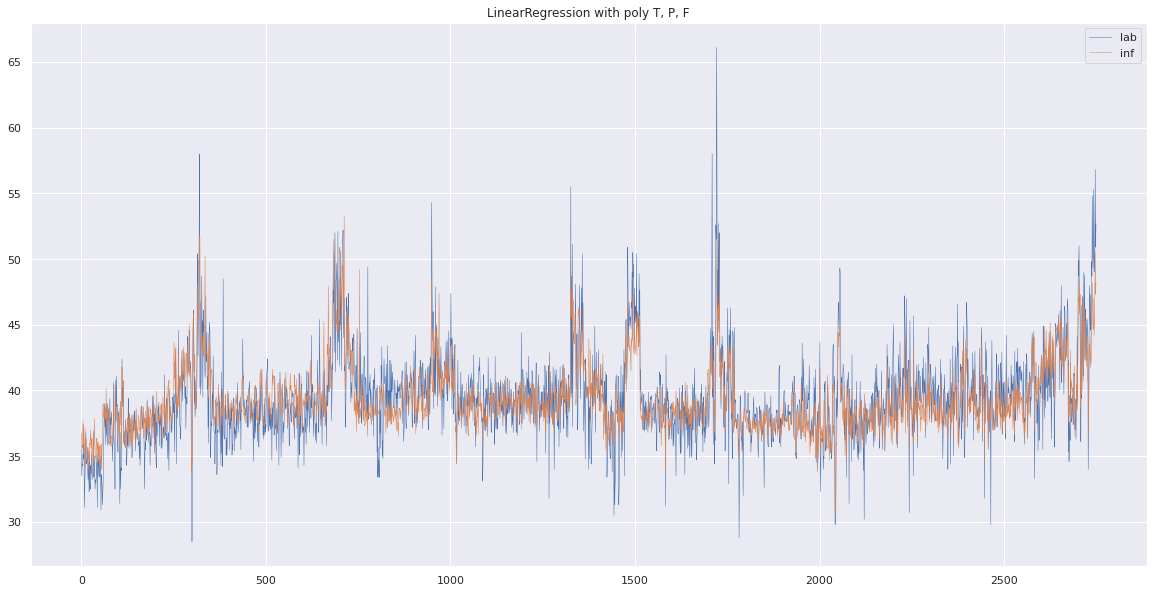

In [71]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), target, label = 'lab', lw = 0.5)
plt.plot(np.arange(2750), inferential, label = 'inf', lw = 0.5)
plt.legend()
plt.title('LinearRegression with poly T, P, F')
plt.show()

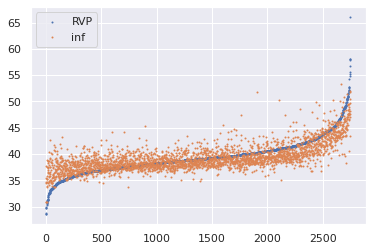

In [72]:
test = pd.DataFrame(target)
test['inf'] = inferential
test = test.sort_values(by = 'RVP')
# test = test.sort_values(by = 'inf')
test.reset_index(drop = True)
plt.scatter(np.arange(2750), test['RVP'], label = 'RVP', s = 1)
plt.scatter(np.arange(2750), test['inf'], label = 'inf', s = 1)
plt.legend()

## Ridge

### Ridge (alpha = 0.001)

In [73]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [74]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,0.001,Standard,0.587097,0.579986,0.58577,0.41423,1.57233,4.639985


### Ridge (alpha = 0.01)

In [75]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [76]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,0.01,Standard,0.586805,0.581653,0.585904,0.414096,1.5711,4.638489


### Ridge (alpha = 0.1)

In [77]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [78]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,0.1,Standard,0.587176,0.563303,0.581625,0.418375,1.575943,4.68642


### Ridge (alpha = 1)

In [79]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [80]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,1,Standard,0.577151,0.575305,0.577049,0.422951,1.57919,4.737674


### Ridge (alpha = 10)

In [81]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [82]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,10,Standard,0.569622,0.571157,0.570624,0.429376,1.588719,4.809639


### Ridge (alpha = 100)

In [83]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [84]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,100,Standard,0.568745,0.553345,0.565124,0.434876,1.596953,4.87125


## Lasso

### Lasso (alpha = 0.001)

In [85]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [86]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 300000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Lasso,0.001,Standard,0.577467,0.581501,0.578907,0.421093,1.57759,4.716858


In [87]:
print(model.coef_)
# print(pf.get_feature_names())
print(pf.get_feature_names_out())

[ 0.         -2.39572206  7.04256746  1.78347748 -0.          0.
 -4.49600132 -5.2868678   2.63786663  0.28579742]
['1' 'T' 'P' 'F' 'T^2' 'T P' 'T F' 'P^2' 'P F' 'F^2']


### Lasso (alpha = 0.01)

In [88]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [89]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Lasso,0.01,Standard,0.57019,0.565622,0.569635,0.430365,1.590362,4.820718


In [90]:
print(model.coef_)
# print(pf.get_feature_names())
print(pf.get_feature_names_out())

[ 0.         -2.60809029  2.96150561 -0.         -0.          0.
 -0.39169126  0.         -0.         -0.        ]
['1' 'T' 'P' 'F' 'T^2' 'T P' 'T F' 'P^2' 'P F' 'F^2']


### Lasso (alpha = 0.1)

In [91]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [92]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 1000000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Lasso,0.1,Standard,0.565802,0.547723,0.561824,0.438176,1.606928,4.908215


In [93]:
print(model.coef_)
# print(pf.get_feature_names())
print(pf.get_feature_names_out())

[ 0.         -2.3385529   2.66764064 -0.         -0.          0.
 -0.12205705  0.         -0.         -0.        ]
['1' 'T' 'P' 'F' 'T^2' 'T P' 'T F' 'P^2' 'P F' 'F^2']


# Result

In [94]:
information

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE,R2,R2_inv
0,"Poly T, P",LinearRegression,NaN,Standard,0.571162,0.566814,1.609327,4.813115,0.570314,0.429686
0,"Poly T, P",Ridge,0.001,Standard,0.568941,0.571801,1.608644,4.813921,0.570242,0.429758
0,"Poly T, P",Ridge,0.010,Standard,0.572154,0.560630,1.608880,4.818423,0.569840,0.430160
0,"Poly T, P",Ridge,0.100,Standard,0.567637,0.561236,1.614241,4.852292,0.566817,0.433183
0,"Poly T, P",Ridge,1.000,Standard,0.564498,0.562950,1.617851,4.877484,0.564568,0.435432
0,"Poly T, P",Ridge,10.000,Standard,0.562141,0.546017,1.626810,4.943456,0.558678,0.441322
0,"Poly T, P",Ridge,100.000,Standard,0.552131,0.557056,1.631064,4.997226,0.553878,0.446122
0,"Poly T, P",Lasso,0.001,Standard,0.568779,0.555032,1.616505,4.865956,0.565597,0.434403
0,"Poly T, P",Lasso,0.010,Standard,0.559657,0.549634,1.629203,4.952387,0.557881,0.442119
0,"Poly T, P",Lasso,0.100,Standard,0.555997,0.546591,1.628419,4.999453,0.553679,0.446321


In [95]:
information.drop(['train_R2', 'test_R2', 'Scaler'], axis=1)

,Variables,Solution,Alpha,MAE,MSE,R2,R2_inv
0,"Poly T, P",LinearRegression,NaN,1.609327,4.813115,0.570314,0.429686
0,"Poly T, P",Ridge,0.001,1.608644,4.813921,0.570242,0.429758
0,"Poly T, P",Ridge,0.010,1.608880,4.818423,0.569840,0.430160
0,"Poly T, P",Ridge,0.100,1.614241,4.852292,0.566817,0.433183
0,"Poly T, P",Ridge,1.000,1.617851,4.877484,0.564568,0.435432
0,"Poly T, P",Ridge,10.000,1.626810,4.943456,0.558678,0.441322
0,"Poly T, P",Ridge,100.000,1.631064,4.997226,0.553878,0.446122
0,"Poly T, P",Lasso,0.001,1.616505,4.865956,0.565597,0.434403
0,"Poly T, P",Lasso,0.010,1.629203,4.952387,0.557881,0.442119
0,"Poly T, P",Lasso,0.100,1.628419,4.999453,0.553679,0.446321


In [96]:
grouped = information['MAE'].groupby(information['Solution']).mean()

In [97]:
grouped.mean()

1.5983003712441992

In [98]:
mins = information[['MAE', 'MSE']].groupby([information['Variables'], information['Solution']]).min()
mins

MAE       MSE
Variables      Solution                            
Poly PCT, P    Lasso             1.616088  4.863770
               LinearRegression  1.609212  4.810791
               Ridge             1.607650  4.810770
Poly PCT, P, F Lasso             1.578132  4.727412
               LinearRegression  1.571993  4.635513
               Ridge             1.572570  4.637468
Poly T, P      Lasso             1.616505  4.865956
               LinearRegression  1.609327  4.813115
               Ridge             1.608644  4.813921
Poly T, P, F   Lasso             1.577590  4.716858
               LinearRegression  1.574659  4.644589
               Ridge             1.571100  4.638489

In [99]:
max = information[['train_R2', 'test_R2']].groupby([information['Variables'], information['Solution']]).max()
max

train_R2   test_R2
Variables      Solution                            
Poly PCT, P    Lasso             0.564381  0.568754
               LinearRegression  0.571584  0.566541
               Ridge             0.573817  0.566608
Poly PCT, P, F Lasso             0.589971  0.567418
               LinearRegression  0.583650  0.589962
               Ridge             0.591042  0.572455
Poly T, P      Lasso             0.568779  0.555032
               LinearRegression  0.571162  0.566814
               Ridge             0.572154  0.571801
Poly T, P, F   Lasso             0.577467  0.581501
               LinearRegression  0.592149  0.562832
               Ridge             0.587176  0.581653

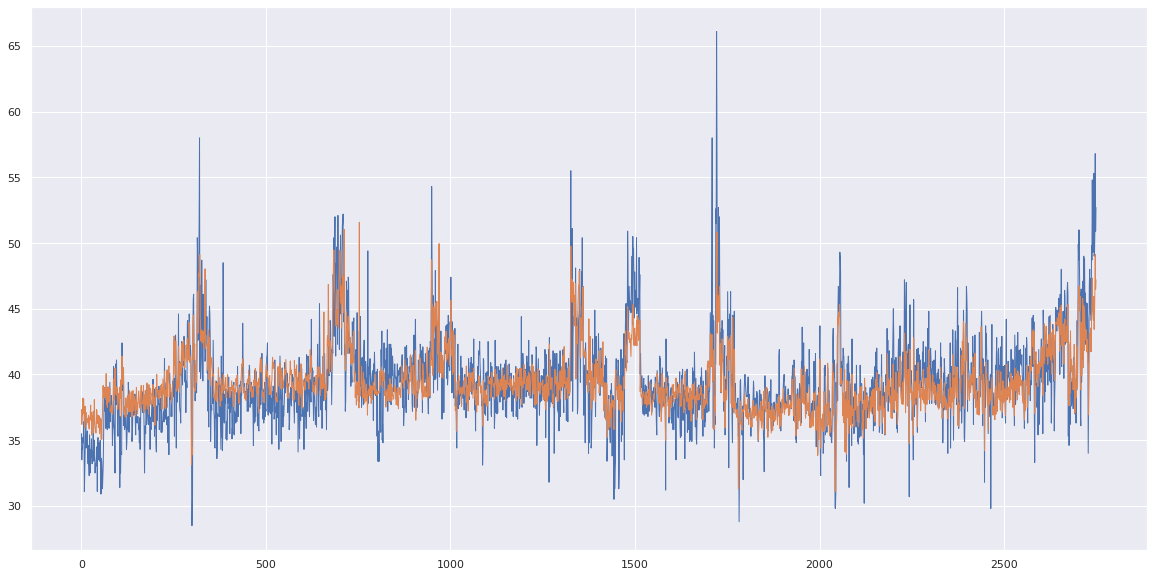

In [100]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), target, lw = 1, label = 'target')
plt.plot(np.arange(2750), inferential, lw = 1, label = 'inf')

In [101]:
xgb = XGBRegressor()

In [102]:
xgb.fit(train_input, train_target)

[06:14:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [103]:
xgb.score(train_input, train_target)

0.7026719216800617

In [104]:
xgb.score(test_input, test_target)

0.5687586233305506

In [105]:
r2_score(target, xgb.predict(input_poly))

0.6484037617329705

In [106]:
inferential = xgb.predict(input_poly)

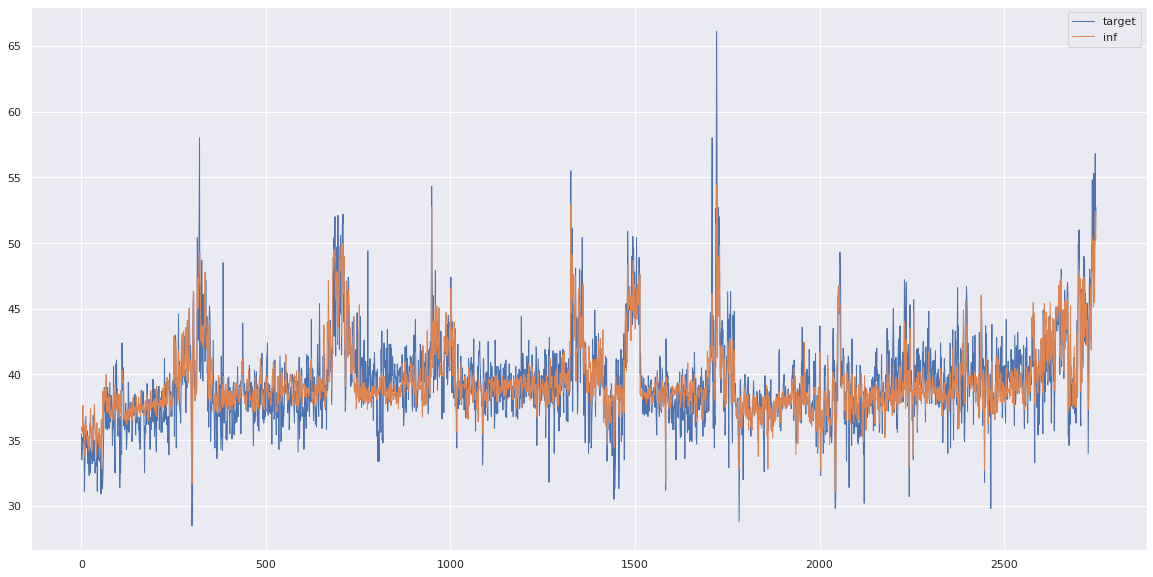

In [107]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), target, lw = 1, label = 'target')
plt.plot(np.arange(2750), inferential, lw = 1, label = 'inf')
plt.legend()

In [108]:
MAE(target, inferential)

1.4594922260631216

In [109]:
MSE(target, inferential)

3.938395494500445

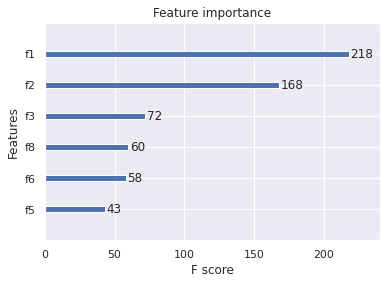

In [110]:
import xgboost
xgboost.plot_importance(xgb)